In [1]:
import  numpy as np
import matplotlib as plt


In [2]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit import QuantumRegister ,ClassicalRegister,QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.aqua.operators import I, X, Y, Z

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
#

/Users/voicutu/opt/anaconda3/envs/newC/lib/python3.7/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [3]:
#jut a dirty trick
from scipy.optimize import minimize
from tools import decompose, expected

In [4]:
backend=Aer.get_backend('qasm_simulator')

In [5]:
#Exact solver for reference:
def Exact_solver(qubitOp):
    ex = NumPyEigensolver(qubitOp)
    result = ex.run()
    ref = result['eigenvalues']
    return np.real(ref)

In [6]:
basis='sto3g'
inter_dist=1.4
# Molecule
atoms = 'H .0 .0 .0; H .0 .0 '+str(inter_dist)
driver = PySCFDriver(atoms, unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis,max_memory=None)

#integral h_{lm} , h_{lmpq}
molecule = driver.run()
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))
#print('# one elctron integral:\n',h1)
#print('# two elctron integral:\n',h2)

HF energy: -1.3194643767935124
# nr. of electrons: 2
# nr. of spin orbitals: 4


In [7]:
ferOp = FermionicOperator(h1=h1, h2=h2)
qubitOp = ferOp.mapping(map_type='jordan_wigner')

In [8]:
print(qubitOp)
print(qubitOp.print_details())

weight=[]
pauli=[]
for w,i in qubitOp._paulis:
    weight.append(w)
    pauli.append(i.to_label())

Representation: paulis, qubits: 4, size: 15
IIII	(-0.8517840380466506+0j)
IIIZ	(0.10053557435398455+0j)
IIZI	(-0.049032364414860446+0j)
IZII	(0.10053557435398452+0j)
ZIII	(-0.04903236441486046+0j)
IIZZ	(0.08678749878785741+0j)
IZIZ	(0.14120468151365045+0j)
XXYY	(0.05575552226867875+0j)
YYYY	(0.05575552226867875+0j)
XXXX	(0.05575552226867875+0j)
YYXX	(0.05575552226867875+0j)
ZIIZ	(0.14254302105653616+0j)
IZZI	(0.14254302105653616+0j)
ZIZI	(0.14891189696596438+0j)
ZZII	(0.08678749878785741+0j)



In [9]:
class swap_t:
    def __init__(self,theata):
        self.theta=theata
        self.mat=np.array([[1,0,0,0],
                           [0,-np.sin(self.theta),np.cos(self.theta),0],
                           [0,np.cos(self.theta),np.sin(self.theta),0],
                           [0,0,0,-1]])
    def get_p(self):
        print('thet=',self.theta)
        print('math=', self.mat)

In [10]:
CN=[[1,0,0,0],
    [0,1,0,0],
    [0,0,0,1],
    [0,0,1,0]]

CRY=[[1, 0,        0,   0],
     [0, np.cos(np.pi/2-7), 0,  -np.sin(np.pi/2-7)],
     [0, 0,         1,  0],
     [0, np.sin(np.pi/2-7),0,np.cos(np.pi/2-7)]]

CRZ=[[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, -1]]

Z=[[1,0],[0,-1]]
I=[[1,0],[0,1]]

RY=[[np.cos(7),np.sin(7)],[np.sin(7),-np.cos(7)]]

cnz=np.matmul(CN,CRY)
print(cnz)
cnzb=np.matmul(cnz,np.kron(Z,I))
print(cnzb)
'''
pen=np.matmul(cnzb,CRZ)
print(pen)
fin=np.matmul(pen,CN)
print(fin)
'''
fin=np.matmul(cnzb,CN)
print(fin)
a= swap_t(7)

[[ 1.          0.          0.          0.        ]
 [ 0.          0.6569866   0.         -0.75390225]
 [ 0.          0.75390225  0.          0.6569866 ]
 [ 0.          0.          1.          0.        ]]
[[ 1.          0.          0.          0.        ]
 [ 0.          0.6569866   0.          0.75390225]
 [ 0.          0.75390225  0.         -0.6569866 ]
 [ 0.          0.         -1.          0.        ]]
[[ 1.          0.          0.          0.        ]
 [ 0.          0.6569866   0.75390225  0.        ]
 [ 0.          0.75390225 -0.6569866   0.        ]
 [ 0.          0.          0.         -1.        ]]


In [11]:
a.get_p()

thet= 7
math= [[ 1.          0.          0.          0.        ]
 [ 0.         -0.6569866   0.75390225  0.        ]
 [ 0.          0.75390225  0.6569866   0.        ]
 [ 0.          0.          0.         -1.        ]]


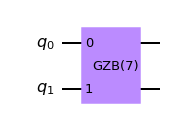

In [12]:
theta=7
def GZB(theta):
    gzb= QuantumCircuit(2,name='GZB('+str(theta)+')')
    gzb.cx(0,1)
    gzb.z(0)
    gzb.cry((np.pi/2-theta)*2,1,0)
    gzb.cx(0,1)
    gate=gzb.to_gate()
    return gate

circ=QuantumCircuit(2)
circ.append(GZB(7),[0,1])
circ.draw('mpl')

In [13]:
from qiskit import execute
backend_mat = Aer.get_backend('unitary_simulator')


#job execution and getting the result as an object
job = execute(circ, backend_mat)
result = job.result()

#get the unitary matrix from the result object
print(result.get_unitary(circ, decimals=0))

[[ 1.        +0.j  0.        -0.j  0.        -0.j  0.        -0.j]
 [ 0.        +0.j -0.6569866 +0.j  0.75390225+0.j  0.        +0.j]
 [ 0.        +0.j  0.75390225+0.j  0.6569866 +0.j  0.        +0.j]
 [ 0.        +0.j -0.        +0.j -0.        +0.j -1.        +0.j]]


In [14]:
def U_t(theta):
    qc=QuantumCircuit(2,name='U_t('+str(theta)+')')
    qc.unitary(swap_t(theta).mat,[0,1])
    return qc.to_gate()

In [15]:
def ansatz_cell(qc,qo,nr_o, nr_e,thetas):
    
    #qo=QuantumRegister(nr_o,'qo')
    #qc=QuantumCircuit(qo,name='ansatz_cell')
    
    it=iter(thetas)
    start=nr_e-1
    limit=nr_o
    while start!=-1:
        cq=start
        tq=start+1
        while tq<limit:
            qc.append(GZB(next(it)),[cq,tq])
            cq=cq+1
            tq=tq+1

        start=start-1
        limit=limit-1
    return qc 


In [16]:
nr_o=num_spin_orbitals
nr_e=num_particles
nr_par=(nr_o-nr_e)*nr_e
theta=np.zeros(nr_par)
print(theta)

[0. 0. 0. 0.]


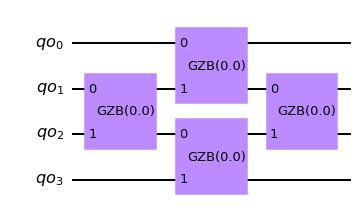

In [17]:
qo=QuantumRegister(nr_o,'qo')
ansatz = QuantumCircuit(qo)
ansatz_cell(ansatz,qo,nr_o, nr_e,theta)
ansatz.draw('mpl')

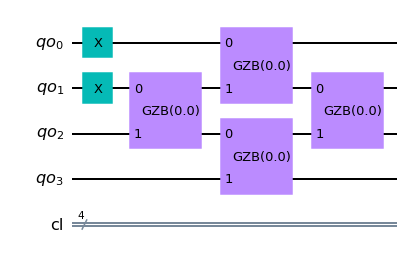

In [18]:
def var_circ(nr_o,nr_e,theta):
    qo=QuantumRegister(nr_o,'qo')
    cb=ClassicalRegister(nr_o,'cl')
    circ = QuantumCircuit(qo,cb)
    for i in range(nr_e):
        circ.x(i)
    ansatz_cell(circ,qo,nr_o, nr_e,theta)
    return circ

circ=var_circ(nr_o,nr_e,theta)
circ.draw('mpl')

In [19]:
# Caluclate final expected value as sum of h[i]<psi|h_obs|psi> where h_obs-> h_label[i].

def value(h,h_label,circ,backend):
    
    val=0
    for i in range(len(h)):
        if h[i]!=0:
            exp=expected(circ,h_label[i],shots=100000,backend=backend)
            val=val+h[i]*exp
            #print('exp for {} ={}'.format(h_label[i],exp))
            
    return (val)

print(value(weight,pauli,circ,backend))

(-1.2535566254215216+0j)


In [20]:
def cost(theta,weight,pauli,nr_o,nr_e,backend):
    circ=var_circ(nr_o,nr_e,theta)
    return value(weight,pauli,circ,backend)

In [21]:
def VQE(weight,pauli,nr_o,nr_e,backend):
    
    theta=np.zeros(nr_par)
    optim=minimize(cost, 
                   theta,args=(weight,pauli,nr_o,nr_e,backend),
                   method='COBYLA', 
                   options={'rhobeg': 1.0, 'maxiter': 2000, 'disp': True, 'catol': 0.0002})
    
    circ=var_circ(nr_o,nr_e,optim.x)
    eigval=value(weight,pauli,circ,backend)
    
    return eigval

In [22]:
VQEresult=np.real(VQE(weight,pauli,nr_o,nr_e,backend))

/Users/voicutu/opt/anaconda3/envs/newC/lib/python3.7/site-packages/scipy/optimize/cobyla.py:262: ComplexWarning: Casting complex values to real discards the imaginary part
  dinfo=info)


In [23]:
print("Result: ",VQEresult)
print("Reference:",Exact_solver(qubitOp))

Result:  -1.3431480574028607
Reference: [-1.39345197]


In [24]:
'''
optimizer= COBYLA(maxiter=500)
backend = Aer.get_backend('statevector_simulator')

vqe = VQE(qubitOp, ansatz, optimizer)
result = vqe.run(backend)
print('VQE:',result.eigenvalue.real ,'Reference:', Exact_solver(qubitOp))
'''

"\noptimizer= COBYLA(maxiter=500)\nbackend = Aer.get_backend('statevector_simulator')\n\nvqe = VQE(qubitOp, ansatz, optimizer)\nresult = vqe.run(backend)\nprint('VQE:',result.eigenvalue.real ,'Reference:', Exact_solver(qubitOp))\n"